In [1]:
# just spend an hour fixing a problem that didn't exist. All because Jan 1 2033 is a weekend...
# TO FIX:
# if im really getting into it: add a refi mode
# good example for graph output at url: https://www.calculator.net/amortization-calculator.html
# ***code breaks at term_year > 75 because of the turn of the century 

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from dateutil.rrule import rrule, WEEKLY, MO
import pandas as pd
import calendar
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt

# functions created for this project (should create links if I ever share this)
from validate_date import validate_date
from business_days import business_days
from cumulative_values import cumulative_values


def loan_amortization(principal, interest_rate,  term_years, start_date, periodtype="M-30"):
    
    """ 
        Args:
        principal (int or float): The principal amount of the loan.
        interest_rate (int or float): The annual interest rate, expressed as a percent (e.g. 5% = 5).
        term_years (int or float): Loan/Borrowing term in years.
        start_date (str or datetime): The start date of the loan in 'YYYY-MM-DD' format or as a datetime object.
        periodtype (str, default="M-30"): The type of period to use for the loan payments, which can be one of the following:
            'D' (daily)
            'bdays' (daily, only includes business days)
            'W' (weekly)
            'BW' (biweekly)
            'M-30' (months where there is 30 days per month and 360 days per year (30/360))
            'M-Actual' (months where months' length are accurate, and there are 360 days per year (Actual/360))
            'Q' (quarterly)
            'S' (semi-annual)
            'Y' (Annual)

    Returns:
        Tuple: (pandas.DataFrame: A DataFrame containing the amortization schedule for the loan),
               (matplotlib.axes.Axes: Axes containing the loan amortization graph)
    """

    if validate_date(start_date) == False:
        raise TypeError("start_date must be a string in 'YYYY-MM-DD' format or a datetime object")
    
    # if the date is in the string format, convert it
    if not isinstance(start_date, datetime):
        start_date = datetime.strptime(start_date, '%Y-%m-%d')
    
    # input type checking for principal, interest_rate, and term_years
    if not isinstance(principal, (int, float)):
        raise TypeError("Principal amount should be numeric (int or float)")
    if not isinstance(interest_rate, (int, float)):
        raise TypeError("Interest rate should be numeric and in % (int or float)")
    if not isinstance(term_years, (int, float)):
        raise TypeError("term_years should be numeric (int or float)")
    
    # shift the day forward one when using Daily to assume no payment is made today
    if periodtype == "D":
        start_date = start_date + timedelta(days=1)
    
    # create end date of term using term_years
    end_date = start_date + timedelta(days=int(365.2422 * term_years))
    
    # create a list of business days for the bday index
    bdays_dates = business_days(start_date, end_date)
    
    # create a list of weeks for weekly and biweekly index
    mondays = list(rrule(WEEKLY, byweekday=MO, dtstart=start_date, until=end_date))
    
    # add one month so that payments are at start of next month
    if periodtype == 'M-30' or periodtype == 'M-Actual':
        if start_date.month == 12:
            # handle special case where the month is December
            new_month = 1
            new_year = start_date.year + 1
        else:
            new_month = start_date.month + 1
            new_year = start_date.year
        start_date_list = start_date.replace(year=new_year, month=new_month)
        month_dates = [start_date_list]
        current_date = start_date_list
        while current_date < end_date:
            current_date += relativedelta(months=1)
            month_dates.append(current_date)
    else:
        start_date_list = start_date
        month_dates = [start_date_list]
        current_date = start_date_list
        while current_date < end_date:
            current_date += relativedelta(months=1)
            month_dates.append(current_date)

    # create list of days in the month of each date
    days_in_month = [calendar.monthrange(date.year, date.month)[1] for date in month_dates]
    
    # period-type definition
    if periodtype == 'D':
        periods = int((end_date - start_date).days) + 1
        days_between_payments = 1
        adjusted_rate = interest_rate / 36524.22
    elif periodtype == 'bdays':
        periods = len(bdays_dates)
        adjusted_rate = interest_rate / 26100
    elif periodtype == 'W':
        periods = int(len(mondays))
        adjusted_rate = interest_rate / 5214
    elif periodtype == 'BW':
        periods = int(len(mondays[::2]))
        adjusted_rate = interest_rate / 2607
    elif periodtype == 'M-30':
        if start_date.month < end_date.month:
            periods = int((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1)
        elif start_date.month > end_date.month:
            periods = int((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) - 1)
        else:
            periods = int((end_date.year - start_date.year) * 12)
        adjusted_rate = interest_rate / 1200
    elif periodtype == 'M-Actual':
        if start_date.month < end_date.month:
            periods = int((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) + 1)
        elif start_date.month > end_date.month:
            periods = int((end_date.year - start_date.year) * 12 + (end_date.month - start_date.month) - 1)
        else:
            periods = int((end_date.year - start_date.year) * 12)
        monthly_rate = [interest_rate / 36000 * days_in_month[i] for i in range(len(month_dates))]
        adjusted_rate = mean(monthly_rate)
    elif periodtype == 'Y':
        periods = int(end_date.year - start_date.year) + 1
        adjusted_rate = interest_rate / 100
    elif periodtype == 'S':
        periods = int(len(month_dates[1::6]))
        adjusted_rate = interest_rate / 200
    elif periodtype == 'Q':
        periods = int(len(month_dates[1::3]))
        adjusted_rate = interest_rate / 400
    else:
        raise TypeError("periodtype should be one of the following: 'D', 'W', 'BW', 'bdays', 'M-30', 'M-Actual', 'Q', 'S', 'Y'")

    monthly_payment = principal * adjusted_rate / (1 - (1 + adjusted_rate) ** (-periods))

    # create a list of dates for each payment
    if periodtype == 'M-Actual' or periodtype == 'M-30':
        payment_dates = month_dates
    elif periodtype == 'Y':
        payment_dates = [(start_date + relativedelta(years=1 * i)).year for i in range(periods)]
    elif periodtype == 'bdays':
        payment_dates = bdays_dates
    elif periodtype == 'W':
        payment_dates = mondays
    elif periodtype == 'BW':
        payment_dates = mondays[::2]
    elif periodtype == 'S':
        payment_dates = month_dates[6::6]
    elif periodtype == 'Q':
        payment_dates = month_dates[3::3]
    else:
        payment_dates = [start_date + relativedelta(days=(days_between_payments * i)) for i in range(periods)]

    # lists for the payment number, payment amount, interest, principal, and balance
    payment_number = list(range(1, periods + 1))
    payment_amount = [monthly_payment] * periods
    interest = []
    principal_paid = []
    beg_balance = [principal]
    end_balance = []
    pct_interest = []
    pct_principal = []

    # interest, principal, and balance for each payment period (exlcuding M-actual)
    if not periodtype == "M-Actual":
        for i in range(periods):
            interest.append(beg_balance[i] * adjusted_rate)
            principal_paid.append(monthly_payment - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i])
            end_balance.append(beg_balance[i] - principal_paid[i])
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append((principal_paid[i] / payment_amount[i]) * 100)
    elif periodtype == "M-Actual":
        for i in range(periods):
            interest.append(beg_balance[i] * monthly_rate[i])
            principal_paid.append(monthly_payment - interest[i])
            beg_balance.append(beg_balance[i] - principal_paid[i])
            end_balance.append(beg_balance[i] - principal_paid[i])
            pct_interest.append((interest[i] / payment_amount[i]) * 100)
            pct_principal.append((principal_paid[i] / payment_amount[i]) * 100)
        principal_paid[-1] = beg_balance[-2]
        payment_amount[-1] = principal_paid[-1] + interest[-1]
        end_balance[-1] = 0

    # make the amortization-schedule dataframe
    data = {
        'Payment Number': payment_number,
        'Payment Date': payment_dates,
        'Beginning Balance': beg_balance[:-1],
        'Payment Amount': payment_amount,
        'Interest Paid': interest,
        'Principal Paid': principal_paid,
        'Ending Balance': end_balance,
        '% Paid In Interest': pct_interest,
        '% Paid To Principal': pct_principal
    }
    df = pd.DataFrame(data)

    # set the index to the payment date
    df.set_index('Payment Date', inplace=True)

    # apply formating for dollar signs and two decimals (new df to retain old format)
    df.index.name = 'Payment Date'
    df['Payment Amount'] = df['Payment Amount'].apply(lambda x: '${:,.2f}'.format(x))
    df['Interest Paid'] = df['Interest Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Principal Paid'] = df['Principal Paid'].apply(lambda x: '${:,.2f}'.format(x))
    df['Beginning Balance'] = df['Beginning Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['Ending Balance'] = df['Ending Balance'].apply(lambda x: '${:,.2f}'.format(x))
    df['% Paid In Interest'] = df['% Paid In Interest'].apply(lambda x: '{:,.3f}%'.format(x))
    df['% Paid To Principal'] = df['% Paid To Principal'].apply(lambda x: '{:,.3f}%'.format(x))
    
    # create stats for plot
    total_payment = sum(payment_amount)
    total_interest = sum(interest)
    
    # format data for graph and create plot
    plot_data = {
        'Balance': beg_balance[:-1],
        'Cumulative Interest': cumulative_values(interest),
        'Principal Paid': cumulative_values(principal_paid)
    }
    plot = sns.lineplot(data=plot_data)
    plot.set_title("Loan Amortization Graph")
    plot.set_xlabel("Time Periods")
    plot.set_ylabel("Amount (in Dollars)")
    plt.annotate(f'Total Payment: ${total_payment:.2f}', xy=((periods * .3), (principal)), xytext=((periods * .3), (principal)))
    plt.annotate(f'Total Interest: ${total_interest:.2f}', xy=((periods * .3), (principal)), xytext=((periods * .3), (principal - (principal * .075))))

    return df, plot

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-02-01,1,"$200,000.00","$1,687.71","$1,000.00",$687.71,"$199,312.29",59.252%,40.748%
2023-03-01,2,"$199,312.29","$1,687.71",$996.56,$691.15,"$198,621.13",59.048%,40.952%
2023-04-01,3,"$198,621.13","$1,687.71",$993.11,$694.61,"$197,926.53",58.843%,41.157%
2023-05-01,4,"$197,926.53","$1,687.71",$989.63,$698.08,"$197,228.45",58.637%,41.363%
2023-06-01,5,"$197,228.45","$1,687.71",$986.14,$701.57,"$196,526.87",58.431%,41.569%
...,...,...,...,...,...,...,...,...
2037-09-01,176,"$8,313.45","$1,687.71",$41.57,"$1,646.15","$6,667.31",2.463%,97.537%
2037-10-01,177,"$6,667.31","$1,687.71",$33.34,"$1,654.38","$5,012.93",1.975%,98.025%
2037-11-01,178,"$5,012.93","$1,687.71",$25.06,"$1,662.65","$3,350.28",1.485%,98.515%


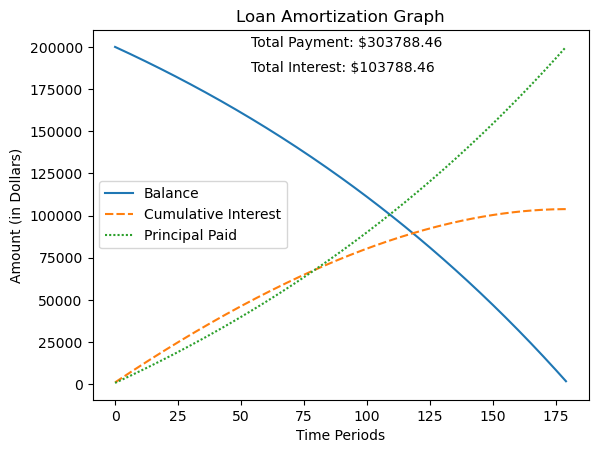

In [2]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1")

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-01-02,1,"$200,000.00",$55.36,$32.85,$22.51,"$199,977.49",59.342%,40.658%
2023-01-03,2,"$199,977.49",$55.36,$32.85,$22.51,"$199,954.98",59.336%,40.664%
2023-01-04,3,"$199,954.98",$55.36,$32.85,$22.52,"$199,932.46",59.329%,40.671%
2023-01-05,4,"$199,932.46",$55.36,$32.84,$22.52,"$199,909.94",59.322%,40.678%
2023-01-06,5,"$199,909.94",$55.36,$32.84,$22.52,"$199,887.41",59.316%,40.684%
...,...,...,...,...,...,...,...,...
2037-12-28,5475,$276.69,$55.36,$0.05,$55.32,$221.37,0.082%,99.918%
2037-12-29,5476,$221.37,$55.36,$0.04,$55.33,$166.04,0.066%,99.934%
2037-12-30,5477,$166.04,$55.36,$0.03,$55.34,$110.70,0.049%,99.951%


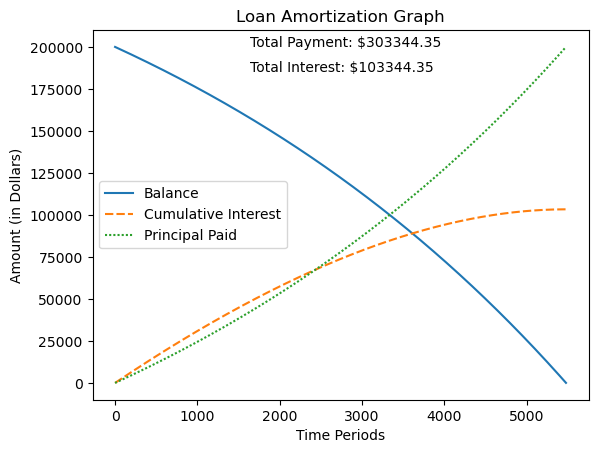

In [3]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'D')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-01-02,1,"$200,000.00",$77.49,$45.98,$31.52,"$199,968.48",59.329%,40.671%
2023-01-03,2,"$199,968.48",$77.49,$45.97,$31.52,"$199,936.96",59.320%,40.680%
2023-01-04,3,"$199,936.96",$77.49,$45.96,$31.53,"$199,905.43",59.311%,40.689%
2023-01-05,4,"$199,905.43",$77.49,$45.96,$31.54,"$199,873.89",59.301%,40.699%
2023-01-06,5,"$199,873.89",$77.49,$45.95,$31.55,"$199,842.34",59.292%,40.708%
...,...,...,...,...,...,...,...,...
2037-12-25,3910,$387.20,$77.49,$0.09,$77.41,$309.80,0.115%,99.885%
2037-12-28,3911,$309.80,$77.49,$0.07,$77.42,$232.38,0.092%,99.908%
2037-12-29,3912,$232.38,$77.49,$0.05,$77.44,$154.94,0.069%,99.931%


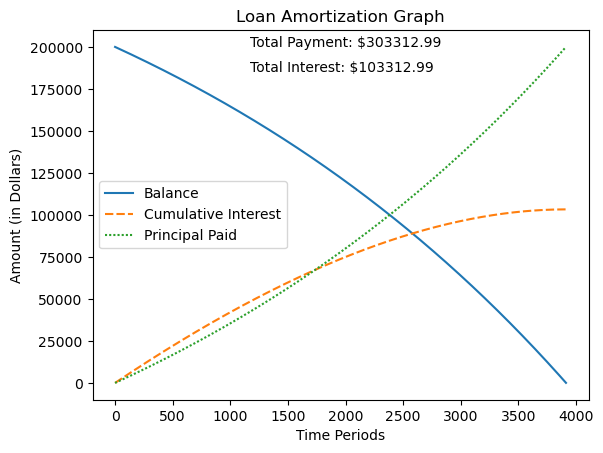

In [4]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'bdays')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-01-02,1,"$200,000.00",$387.69,$230.15,$157.54,"$199,842.46",59.364%,40.636%
2023-01-09,2,"$199,842.46",$387.69,$229.97,$157.72,"$199,684.73",59.317%,40.683%
2023-01-16,3,"$199,684.73",$387.69,$229.79,$157.90,"$199,526.83",59.270%,40.730%
2023-01-23,4,"$199,526.83",$387.69,$229.61,$158.09,"$199,368.74",59.224%,40.776%
2023-01-30,5,"$199,368.74",$387.69,$229.42,$158.27,"$199,210.47",59.177%,40.823%
...,...,...,...,...,...,...,...,...
2037-11-30,779,"$1,931.78",$387.69,$2.22,$385.47,"$1,546.32",0.573%,99.427%
2037-12-07,780,"$1,546.32",$387.69,$1.78,$385.91,"$1,160.40",0.459%,99.541%
2037-12-14,781,"$1,160.40",$387.69,$1.34,$386.36,$774.05,0.344%,99.656%


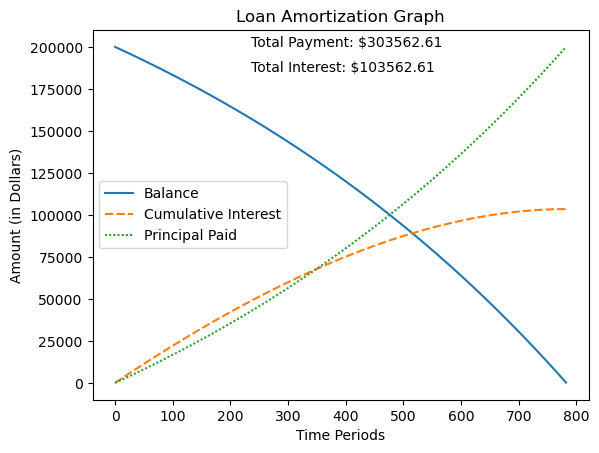

In [5]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'W')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-01-02,1,"$200,000.00",$775.05,$460.30,$314.75,"$199,685.25",59.390%,40.610%
2023-01-16,2,"$199,685.25",$775.05,$459.57,$315.47,"$199,369.78",59.296%,40.704%
2023-01-30,3,"$199,369.78",$775.05,$458.85,$316.20,"$199,053.58",59.203%,40.797%
2023-02-13,4,"$199,053.58",$775.05,$458.12,$316.93,"$198,736.65",59.109%,40.891%
2023-02-27,5,"$198,736.65",$775.05,$457.39,$317.66,"$198,418.99",59.015%,40.985%
...,...,...,...,...,...,...,...,...
2037-11-02,388,"$3,848.63",$775.05,$8.86,$766.19,"$3,082.44",1.143%,98.857%
2037-11-16,389,"$3,082.44",$775.05,$7.09,$767.95,"$2,314.48",0.915%,99.085%
2037-11-30,390,"$2,314.48",$775.05,$5.33,$769.72,"$1,544.76",0.687%,99.313%


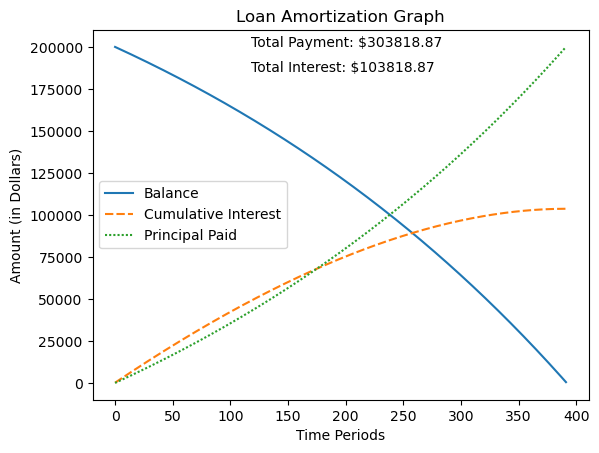

In [6]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'BW')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-04-01,1,"$200,000.00","$5,078.69","$3,000.00","$2,078.69","$197,921.31",59.070%,40.930%
2023-07-01,2,"$197,921.31","$5,078.69","$2,968.82","$2,109.87","$195,811.45",58.456%,41.544%
2023-10-01,3,"$195,811.45","$5,078.69","$2,937.17","$2,141.51","$193,669.93",57.833%,42.167%
2024-01-01,4,"$193,669.93","$5,078.69","$2,905.05","$2,173.64","$191,496.30",57.201%,42.799%
2024-04-01,5,"$191,496.30","$5,078.69","$2,872.44","$2,206.24","$189,290.06",56.559%,43.441%
2024-07-01,6,"$189,290.06","$5,078.69","$2,839.35","$2,239.33","$187,050.72",55.907%,44.093%
2024-10-01,7,"$187,050.72","$5,078.69","$2,805.76","$2,272.92","$184,777.80",55.246%,44.754%
2025-01-01,8,"$184,777.80","$5,078.69","$2,771.67","$2,307.02","$182,470.78",54.574%,45.426%
2025-04-01,9,"$182,470.78","$5,078.69","$2,737.06","$2,341.62","$180,129.16",53.893%,46.107%


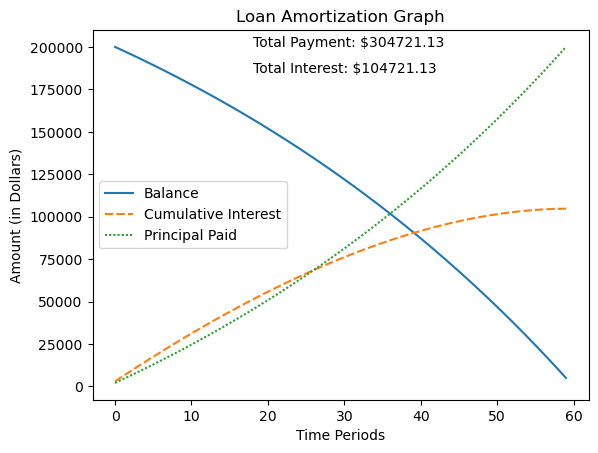

In [7]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'Q')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-07-01,1,"$200,000.00","$10,203.85","$6,000.00","$4,203.85","$195,796.15",58.801%,41.199%
2024-01-01,2,"$195,796.15","$10,203.85","$5,873.88","$4,329.97","$191,466.18",57.565%,42.435%
2024-07-01,3,"$191,466.18","$10,203.85","$5,743.99","$4,459.87","$187,006.31",56.292%,43.708%
2025-01-01,4,"$187,006.31","$10,203.85","$5,610.19","$4,593.66","$182,412.65",54.981%,45.019%
2025-07-01,5,"$182,412.65","$10,203.85","$5,472.38","$4,731.47","$177,681.18",53.631%,46.369%
2026-01-01,6,"$177,681.18","$10,203.85","$5,330.44","$4,873.42","$172,807.76",52.239%,47.761%
2026-07-01,7,"$172,807.76","$10,203.85","$5,184.23","$5,019.62","$167,788.14",50.807%,49.193%
2027-01-01,8,"$167,788.14","$10,203.85","$5,033.64","$5,170.21","$162,617.94",49.331%,50.669%
2027-07-01,9,"$162,617.94","$10,203.85","$4,878.54","$5,325.31","$157,292.62",47.811%,52.189%


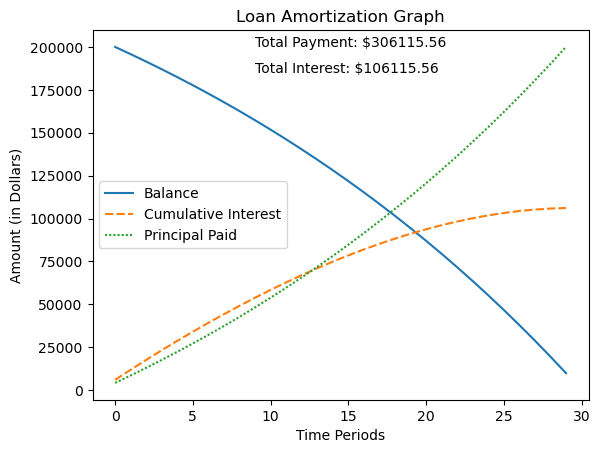

In [8]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'S')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023,1,"$200,000.00","$20,592.55","$12,000.00","$8,592.55","$191,407.45",58.273%,41.727%
2024,2,"$191,407.45","$20,592.55","$11,484.45","$9,108.11","$182,299.34",55.770%,44.230%
2025,3,"$182,299.34","$20,592.55","$10,937.96","$9,654.59","$172,644.75",53.116%,46.884%
2026,4,"$172,644.75","$20,592.55","$10,358.68","$10,233.87","$162,410.88",50.303%,49.697%
2027,5,"$162,410.88","$20,592.55","$9,744.65","$10,847.90","$151,562.98",47.321%,52.679%
2028,6,"$151,562.98","$20,592.55","$9,093.78","$11,498.77","$140,064.21",44.161%,55.839%
2029,7,"$140,064.21","$20,592.55","$8,403.85","$12,188.70","$127,875.51",40.810%,59.190%
2030,8,"$127,875.51","$20,592.55","$7,672.53","$12,920.02","$114,955.48",37.259%,62.741%
2031,9,"$114,955.48","$20,592.55","$6,897.33","$13,695.22","$101,260.26",33.494%,66.506%


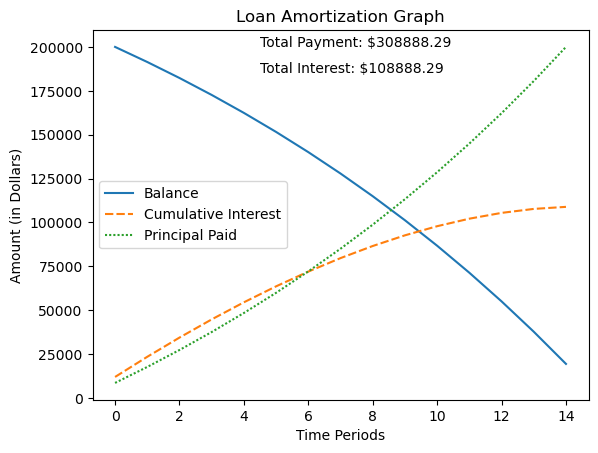

In [9]:
schedule = loan_amortization(200000, 6, 15, "2023-1-1", 'Y')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-02-01,1,"$200,000.00",$898.09,$583.33,$314.76,"$199,685.24",64.953%,35.047%
2023-03-01,2,"$199,685.24",$898.09,$582.42,$315.67,"$199,369.57",64.850%,35.150%
2023-04-01,3,"$199,369.57",$898.09,$581.49,$316.59,"$199,052.98",64.748%,35.252%
2023-05-01,4,"$199,052.98",$898.09,$580.57,$317.52,"$198,735.46",64.645%,35.355%
2023-06-01,5,"$198,735.46",$898.09,$579.65,$318.44,"$198,417.01",64.542%,35.458%
...,...,...,...,...,...,...,...,...
2052-09-01,356,"$4,451.42",$898.09,$12.98,$885.11,"$3,566.32",1.446%,98.554%
2052-10-01,357,"$3,566.32",$898.09,$10.40,$887.69,"$2,678.63",1.158%,98.842%
2052-11-01,358,"$2,678.63",$898.09,$7.81,$890.28,"$1,788.35",0.870%,99.130%


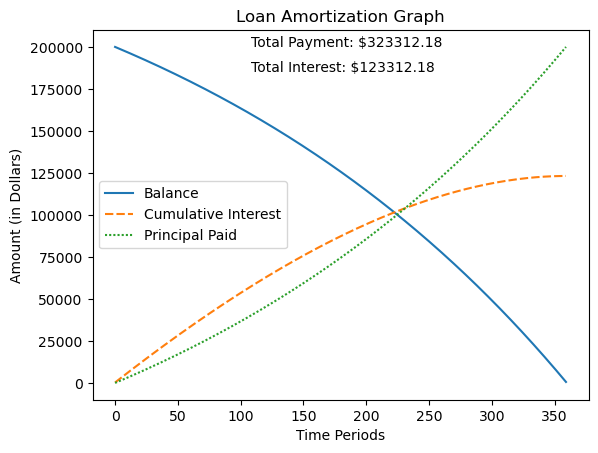

In [10]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-30')

schedule[0]

,Payment Number,Beginning Balance,Payment Amount,Interest Paid,Principal Paid,Ending Balance,% Paid In Interest,% Paid To Principal
Payment Date,,,,,,,,
2023-02-01,1,"$200,000.00",$903.82,$544.44,$359.37,"$199,640.63",60.238%,39.762%
2023-03-01,2,"$199,640.63",$903.82,$601.69,$302.12,"$199,338.51",66.573%,33.427%
2023-04-01,3,"$199,338.51",$903.82,$581.40,$322.41,"$199,016.10",64.328%,35.672%
2023-05-01,4,"$199,016.10",$903.82,$599.81,$304.00,"$198,712.09",66.364%,33.636%
2023-06-01,5,"$198,712.09",$903.82,$579.58,$324.24,"$198,387.85",64.126%,35.874%
...,...,...,...,...,...,...,...,...
2052-09-01,356,"$4,404.16",$903.82,$12.85,$890.97,"$3,513.19",1.421%,98.579%
2052-10-01,357,"$3,513.19",$903.82,$10.59,$893.23,"$2,619.96",1.172%,98.828%
2052-11-01,358,"$2,619.96",$903.82,$7.64,$896.17,"$1,723.79",0.845%,99.155%


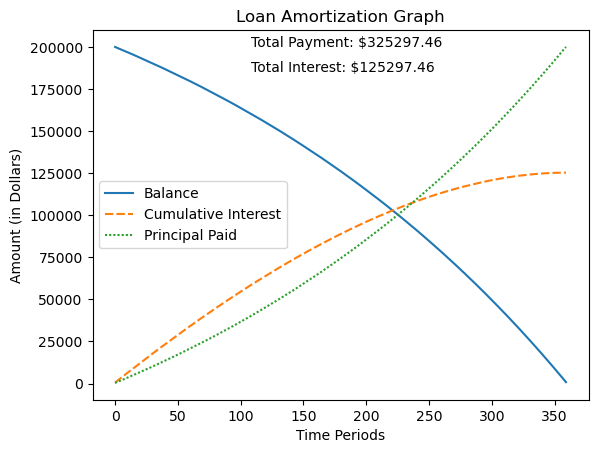

In [11]:
schedule = loan_amortization(200000, 3.5, 30, "2023-1-1", 'M-Actual')

schedule[0]